In [ ]:
%matplotlib inline
import numpy as np

from random import randint
from _thread import start_new_thread
from time import sleep, time

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from ts_outlier_detection import *
from ts_outlier_detection.plotting import *
from utils import *

def insert_event_data(target, failures, det, gps_time, start, retries=2):
    try:
        target.append([
            get_processed_event(det, gps_time, length=2, bp=[(20, 300)])[0],
            gps_time
        ])
        print(f'Fetched {len(target)} events after {round(time()-start, 2)} seconds')
    except Exception as e:
        print(f'Error fetching event from {det} at {gps_time}: {e}')
        if retries > 0:
            print(f'Retrying {retries-1} more times')
            sleep(randint(0, 15))
            insert_event_data(target, failures, det, gps_time, start, retries=retries-1)
        else:
            print('No more retries')
            failures.append(gps_time)

## Gradient descent function

def gradient_descent(
    params, learning_rate, training_set, loss_function,
    epochs=3, batch_size=5, max_iter=100, seed=42, threshold=1e-4
):
    rng = np.random.default_rng(seed)
    for epoch in range(epochs):
        print(f'Starting training epoch {epoch+1}/{epochs}')
        rng.shuffle(training_set)
        avg_losses = []

        for i in tqdm(range(0, len(training_set), batch_size)):
            for _ in range(max_iter):
                grad = np.zeros(3)
                batch_loss = 0

                for ts, actual in training_set[i:i+batch_size]:
                    data = ts.value
                    times = ts.times.value

                    def loss(d, n, e):
                        ctof = TemporalOutlierFactor(dims=d, n_neighbors=n, event_length=e)
                        ctof.fit(data, times)
                        return loss_function(actual, times[ctof.get_outlier_indices()])

                    batch_loss += loss(*params)
                    grad += estimate_gradient(loss, params, eps=1)

                grad /= batch_size
                avg_losses.append(batch_loss/batch_size)
                delta = (learning_rate * grad).astype(int)
                if np.max(np.abs(delta)) < threshold:
                    break
                params -= delta
                for i in range(params.size):
                    if params[i] < 2:
                        params[i] = 2
    
        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        ax.set_title(f'Epoch {epoch+1} losses')
        ax.plot(np.arange(len(avg_losses)), avg_losses, 'k.')
        ax.set_xlabel('Batch number')
        ax.set_ylabel('Average loss over batch')
        ax.grid(True)
        print(f'Current optimal parameters: {params}')
        
    return params

In [20]:
from pandas import read_csv

time_header = 'GPStime'
fast_scattering = 'Fast Scattering'
koi_fish = 'Koi Fish'
scattered_light = 'Scattered Light'

h1_fast_scattering_df = read_csv('data/H1_ Fast scattering - Sheet1 (1).csv')
h1_koi_fish_df =        read_csv('data/H1_ Koi Fish - gspy (7) (2).csv')
h1_scattered_light_df = read_csv('data/H1_ Scattered light - gspy (1).csv')
l1_fast_scattering_df = read_csv('data/L1_ Fast-scattering - gspy (6) (1).csv')
l1_koi_fish_df =        read_csv('data/L1_ Koi Fish - Sheet1 (1).csv')
l1_scattered_light_df = read_csv('data/L1_ Scattered Light - gspy (1) (1).csv')

H1_GLITCHES = {
    fast_scattering: h1_fast_scattering_df[time_header].to_numpy(),
    koi_fish:        h1_koi_fish_df[time_header].to_numpy(),
    scattered_light: h1_scattered_light_df[time_header].to_numpy()
}

L1_GLITCHES = {
    fast_scattering: l1_fast_scattering_df[time_header].to_numpy(),
    koi_fish:        l1_koi_fish_df[time_header].to_numpy(),
    scattered_light: l1_scattered_light_df[time_header].to_numpy()
}

ALL_GLITCHES = {'H1': H1_GLITCHES, 'L1': L1_GLITCHES}

for det, glitches in ALL_GLITCHES.items():
    for kind, times in glitches.items():
        print(f'{det} has {times.size} {kind} glitches')

H1 has 999 Fast Scattering glitches
H1 has 100 Koi Fish glitches
H1 has 999 Scattered Light glitches
L1 has 999 Fast Scattering glitches
L1 has 100 Koi Fish glitches
L1 has 999 Scattered Light glitches


In [5]:
## Koi Fish

koi_fish_times = []
for det, glitches in ALL_GLITCHES.items():
    print(f'Fetching {koi_fish} events from {det}')
    koi_fish_times.extend([(det, glitch) for glitch in glitches[koi_fish]])

koi_fish_ts = []
koi_fish_failed_times = []

start = time()
for det, gps_time in koi_fish_times:
    start_new_thread(insert_event_data, (koi_fish_ts, failed_times, det, gps_time, start, 0))
    sleep(10)

training_size = 0.8
split_idx = int(training_size*len(koi_fish_ts))
training_set = koi_fish_ts[:split_idx]
test_set = koi_fish_ts[split_idx:]

Fetching Koi Fish events from H1
Fetching Koi Fish events from L1
Fetched 1 events after 30.6 seconds
Fetched 2 events after 48.1 seconds
Fetched 3 events after 64.69 seconds
Fetched 4 events after 87.99 seconds
Fetched 5 events after 114.1 seconds
Fetched 6 events after 114.4 seconds
Fetched 7 events after 138.29 seconds
Fetched 8 events after 161.9 seconds
Fetched 9 events after 189.3 seconds
Fetched 10 events after 189.49 seconds
Fetched 11 events after 209.39 seconds
Fetched 12 events after 228.54 seconds
Fetched 13 events after 254.79 seconds
Fetched 14 events after 254.9 seconds
Fetched 15 events after 267.99 seconds
Fetched 16 events after 280.49 seconds
Fetched 17 events after 294.39 seconds
Fetched 18 events after 304.01 seconds
Fetched 19 events after 327.0 seconds
Fetched 20 events after 352.19 seconds
Fetched 21 events after 371.79 seconds
Fetched 22 events after 371.9 seconds
Fetched 23 events after 403.6 seconds
Fetched 24 events after 415.5 seconds
Fetched 25 events afte

Starting training epoch 1/3


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Current optimal parameters: [   2  114 1016]
Starting training epoch 2/3


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Current optimal parameters: [   2  114 1016]
Starting training epoch 3/3


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Current optimal parameters: [   2  114 1016]


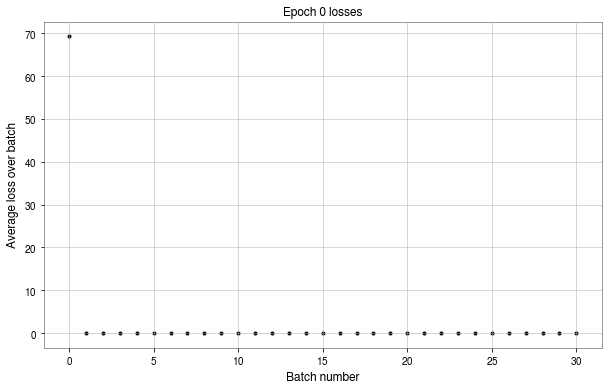

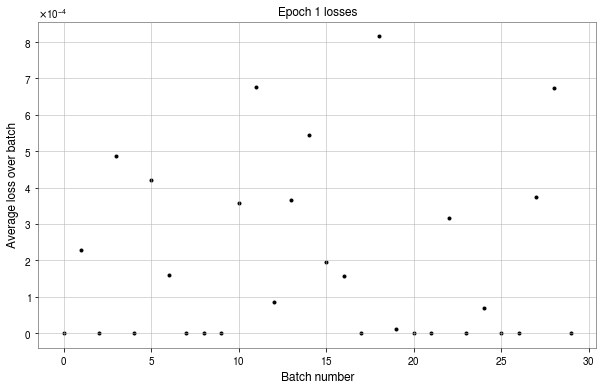

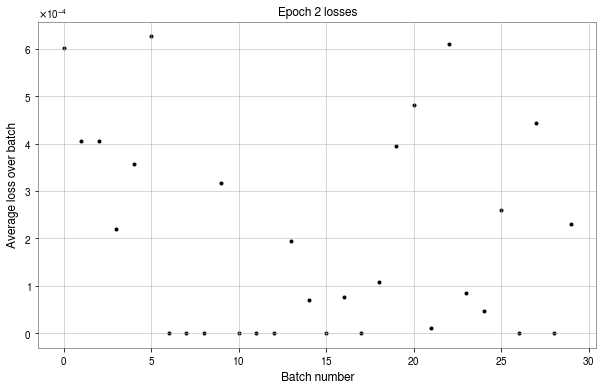

In [11]:
### Parameters to optimize (dims, n_neighbors, event_length)
params = np.array([3, 4, 1024]) # initial values
learning_rate = np.array([3, 3, 30])
###

## Gradient descent
best_dims, best_k, best_length = gradient_descent(
    params, learning_rate, training_set, diff_loss,
    epochs=3, batch_size=5, max_iter=100, seed=42
)

In [ ]:
## Testing
optimal_tof = TemporalOutlierFactor(dims=best_dims, n_neighbors=best_k, event_length=best_length)



In [ ]:
## Fast Scattering

fast_scattering_times = []
for det, glitches in ALL_GLITCHES.items():
    print(f'Fetching {fast_scattering} events from {det}')
    fast_scattering_times.extend([(det, glitch) for glitch in glitches[fast_scattering]])

fast_scattering_ts = []
fast_scattering_failed_times = []

start = time()
for det, gps_time in fast_scattering_times:
    start_new_thread(insert_event_data, (fast_scattering_ts, fast_scattering_failed_times, det, gps_time, start, 3))

training_size = 0.8
split_idx = int(training_size*len(fast_scattering_ts))
training_set = fast_scattering_ts[:split_idx]
test_set = fast_scattering_ts[split_idx:]